# Alzeheimer's Classification Using FCN and CNN

## Checking hardware and allocate device used

In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 1.12.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [2]:
import torch  
from torch import nn, optim  
import torch.nn.functional as F 
from torchvision import datasets, transforms 

# normalize the tensor to -1, 1, one channel

data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,
                         std=0.229)
])

# Batch size
batch_size = 64


orig_dir = "./Alzheimer_Dataset" # Source of data
orig_set = datasets.ImageFolder(orig_dir,transform=data_transforms) #returns a iterator trainset
n = len(orig_set)

#training sample size
trainsize = 5900
trainset, testset = torch.utils.data.random_split(orig_set, [trainsize, n-trainsize])


print(f'number of full dataset is: {n}')
print(f'number of train dataset is: {len(trainset)}')
print(f'number of test dataset is: {len(testset)}')

# Loaders for train and test dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

number of full dataset is: 6400
number of train dataset is: 5900
number of test dataset is: 500


torch.Size([64, 1, 128, 128])
tensor([3, 3, 2, 2, 0, 2, 2, 2, 2, 3, 2, 3, 2, 0, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2,
        2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 0, 3, 0, 2, 2, 2, 3, 3, 2, 2, 3, 3,
        2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3], device='mps:0')


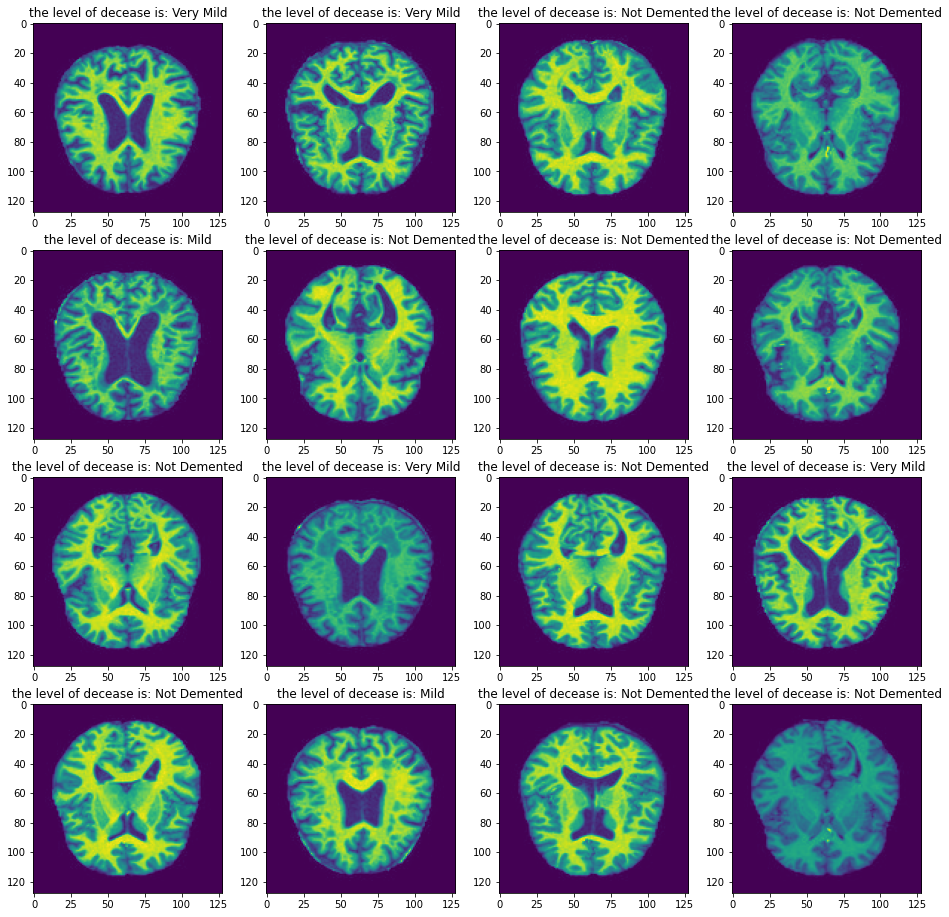

In [9]:
image, label = next(iter(trainloader))
image = image.to(device)
label = label.to(device)

print(image.shape)


fig, axes = plt.subplots(4, 4, figsize=(16, 16))

labellist = ['Mild','Moderate','Not Demented','Very Mild']
num = 0
for i in range(4):
    for j in range(4):
        imagedemo = image[num]
        imagedemo = imagedemo.reshape((128,128))
        axes[i, j].imshow(imagedemo.cpu())
        imagedemolabel = label[num]
        axes[i, j].set_title(f"the level of decease is: {labellist[imagedemolabel]}")
        num = num+1
        
print(label)
plt.show()

Move the Data to GPU

## Contruct a FCN model on the data set

### The FCN network consists of 3 hidden layers, each of decreasing number of neurons

In [4]:
import torch.nn.functional as F

class Classifier(nn.Module):
    
    
    def __init__(self):
        super().__init__()
        self.NumL1 = 1048
        self.NumL2 = 512
        self.NumL3 = 256

        self.fc1 = nn.Linear(16384, self.NumL1) 
        # Applies a linear transformation to the incoming data, spit out output in dimension
        # The weight is random initially, set to a sample from distribution based on sample size
        self.fc2 = nn.Linear(self.NumL1, self.NumL2)
        self.fc3 = nn.Linear(self.NumL2, self.NumL3)
        self.fc4 = nn.Linear(self.NumL3, 4)

        #four types of decease level
        
        # An important regularization to control influence on a single neutron on the result
        # Done by killing some neurons to prevent overfitting(20%)
        self.dropout = nn.Dropout(p=0.0)
        
    def forward(self, x):
        # make sure input tensor (x) is flattened into 1d
        x = x.view(x.shape[0], -1)
        
        #after 1 forward, the ongoing result is linear transformation of input followed by ReLu
        x = self.dropout(F.relu(self.fc1(x)))
        #So on and so forth
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        #Finally the prediction is the fc4
        x = F.log_softmax(self.fc4(x), dim=1)
        
        
        #each forward call returns a prediction based on the input
        return x

### Run the network based on learning rate = 0.05% and 0 dropouts

In [5]:
#initialize a new instance of Classifier()
model = Classifier()
#model = model.to(device)

# Loss function: Net Log Loss
criterion = nn.NLLLoss()

# Adam Grad for optimizer, with learning rate of 0.00005
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# 100 epochs
epochs = 100


train_losses, test_losses, accuracies = [], [], []

print('Start Training')
for e in range(epochs):
    running_loss = 0
    
    # all pictures in the train set
    for images, labels in trainloader:
        #images = images.to(device)
        #labels = labels.to(device)

        # intialize grad to 0 otherwise data from backward propogation will pile up
        optimizer.zero_grad()
        
        # train each batch and find gradient through backward propogation, update loss
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # if no more batches to train, go to test mode for 
    else:
        test_loss = 0
        accuracy = 0
        # turn to no grad in test
        with torch.no_grad():
            # Turn of the Dropout
            model.eval()
            
            # for all images in test loader, predict
            for images, labels in testloader:
                #images = images.to(device)
                #labels = labels.to(device)

                # prediction, calculate loss and update on results
                log_ps = model(images) # prediction of test image
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                # calculating the newest accuracy
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # Tirning Dropout back on
        model.train()
        # Updating accuracies and loss list
        accuracies.append(accuracy/len(testloader))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("epoch went through: {}/{}.. ".format(e+1, epochs),
              "train loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "test loss:  {:.3f}.. ".format(test_loss/len(testloader)),
              "model accuracy: {:.3f}".format(accuracy/len(testloader)))

Start Training
epoch went through: 1/100..  train loss: 0.967..  test loss:  0.877..  model accuracy: 0.573
epoch went through: 2/100..  train loss: 0.860..  test loss:  0.789..  model accuracy: 0.667
epoch went through: 3/100..  train loss: 0.765..  test loss:  0.728..  model accuracy: 0.629
epoch went through: 4/100..  train loss: 0.668..  test loss:  0.588..  model accuracy: 0.761
epoch went through: 5/100..  train loss: 0.554..  test loss:  0.625..  model accuracy: 0.738
epoch went through: 6/100..  train loss: 0.464..  test loss:  0.584..  model accuracy: 0.704
epoch went through: 7/100..  train loss: 0.403..  test loss:  0.368..  model accuracy: 0.858
epoch went through: 8/100..  train loss: 0.295..  test loss:  0.474..  model accuracy: 0.794
epoch went through: 9/100..  train loss: 0.241..  test loss:  0.303..  model accuracy: 0.883
epoch went through: 10/100..  train loss: 0.179..  test loss:  0.215..  model accuracy: 0.927
epoch went through: 11/100..  train loss: 0.164..  tes

epoch went through: 89/100..  train loss: 0.000..  test loss:  0.008..  model accuracy: 0.996
epoch went through: 90/100..  train loss: 0.000..  test loss:  0.010..  model accuracy: 0.996
epoch went through: 91/100..  train loss: 0.000..  test loss:  0.010..  model accuracy: 0.996
epoch went through: 92/100..  train loss: 0.000..  test loss:  0.009..  model accuracy: 0.996
epoch went through: 93/100..  train loss: 0.000..  test loss:  0.009..  model accuracy: 0.996
epoch went through: 94/100..  train loss: 0.000..  test loss:  0.007..  model accuracy: 0.996
epoch went through: 95/100..  train loss: 0.000..  test loss:  0.009..  model accuracy: 0.996
epoch went through: 96/100..  train loss: 0.000..  test loss:  0.009..  model accuracy: 0.996
epoch went through: 97/100..  train loss: 0.000..  test loss:  0.008..  model accuracy: 0.996
epoch went through: 98/100..  train loss: 0.000..  test loss:  0.008..  model accuracy: 0.994
epoch went through: 99/100..  train loss: 0.000..  test loss

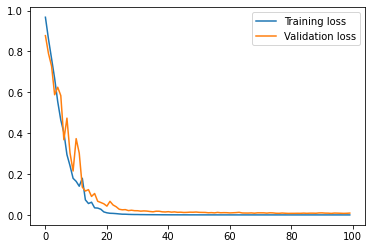

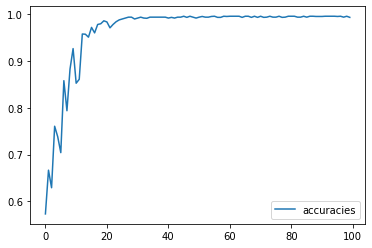

In [6]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.show()
plt.plot(accuracies,label = 'accuracies')
plt.legend()
plt.show()

### Run on test set and predict

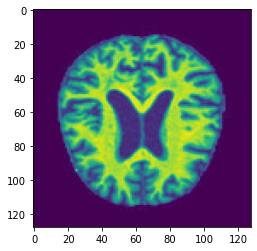

The FCN predicts a: Very Mild level of decease in the picture，with a confidence of 99.99998807907104% : 


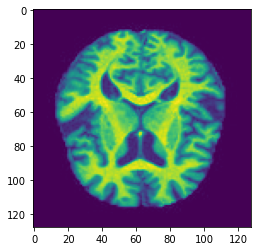

The FCN predicts a: Very Mild level of decease in the picture，with a confidence of 100.0% : 


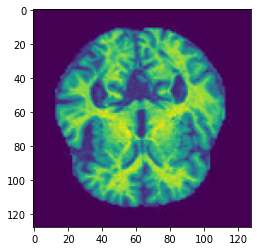

The FCN predicts a: Not Demented level of decease in the picture，with a confidence of 100.0% : 


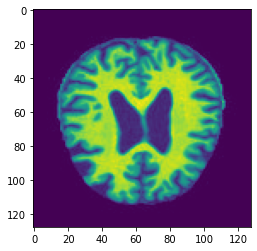

The FCN predicts a: Very Mild level of decease in the picture，with a confidence of 99.9981164932251% : 


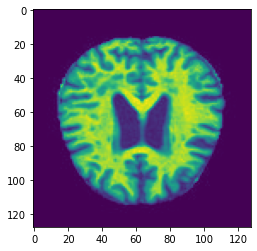

The FCN predicts a: Not Demented level of decease in the picture，with a confidence of 99.99992847442627% : 


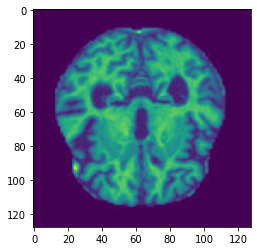

The FCN predicts a: Very Mild level of decease in the picture，with a confidence of 99.62393045425415% : 


In [7]:
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
for i in range(6):
    img = images[i]
    img = img.reshape((128,128))
    plt.imshow(img)
    plt.show()

    
    #img = torch.from_numpy(img)
    img = img.view(1, 128*128)

    # forward prediction
    with torch.no_grad():
        output = model.forward(img)
    ps = torch.exp(output)

    top_p, top_class = ps.topk(1, dim=1)
    labellist = ['Mild','Moderate','Not Demented','Very Mild']
    prediction = labellist[top_class]
    probability = float(top_p)
    print(f'The FCN predicts a: {prediction} level of decease in the picture，with a confidence of {probability*100}% : ')